In [1]:
import sys
sys.path.insert(
    0, '/Users/aibrahi2/Research/Bayesian_Inference-ML-Atmospheric_Correction/src')

from forward_model import fwModel 
import numpy as np
import pickle
from acModel import acInferModel
from acModel import PyMCModel
from scipy.interpolate import RegularGridInterpolator as RGI
import LUT_generator.ac_likelihood_w_chlor as ac_likelihood_w_chlor
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))


Using TensorFlow backend.


Opening /Users/aibrahi2/Research/Bayesian_Inference-ML-Atmospheric_Correction/data/tables/aerosol_ref_transmittance_LUT.nc
Opening /Users/aibrahi2/Research/Bayesian_Inference-ML-Atmospheric_Correction/data/tables/Rayleigh_LUT.nc
Running on PyMC3 v3.8


In [2]:
NN_path = '../../data/NN_model/best_model_pca_tf_lognorm/'
scaler_path = '../../data/NN_model/best_model_pca_tf_lognorm_input_scaler.bin'
fwd = fwModel(NN_path, scaler_path)
fwd.load_NN(scaler_path)
forward_model = fwd.forward_model



Loaded Neural Network model.


In [3]:
inputs_ = (np.array([1153.298, 8.390237, 61.282, 0.43858594, 58.54474, 0.36724114, 1.2139493, 1.330425, 66.43, 121.61, 28.43]))
pr=1153.298
ws =  8.390237
rh = 61.282
o3 = 0.43858594
wv = 1.2139493
solz = 66.43
relaz = 121.61
senz = 28.43
(forward_model(inputs_))[0:13].eval()

array([0.35400612, 0.3175612 , 0.28843159, 0.26350657, 0.21184932,
       0.19553698, 0.18856959, 0.14801267, 0.14763979, 0.14663667,
       0.12892459, 0.10226408, 0.10208727])

In [4]:
def σ_per_geom(solz, relaz, senz):
    diff_per_geom = np.load('../../data/NN_model/diff_per_geom.npy')
    θ0 = np.linspace(0, 80, 9)
    ϕ = np.linspace(0, 180, 19)
    θ = np.linspace(0, 70, 8)
    return RGI((θ0, ϕ, θ), diff_per_geom)((solz, relaz, senz))


In [5]:
# observations = (forward_model(inputs_))[0:13].eval()
# anc = [pr, ws, rh, o3, wv, ]
# anc_unc=[0.025,0.025,0.025,0.025,0.025]
# geom = (solz, relaz, senz)
# prior_dist = 'uniform'

In [5]:
with open('/Users/aibrahi2/Research/atmocor/chlor_based_ret/in_out_na_df.pkl', 'rb') as pickle_file:
    in_out_na_df = pickle.load(pickle_file)

NN = 0
LUT = 1

for i in range(1):
    pr = in_out_na_df['pr'].values[i]
    ws = in_out_na_df['ws'].values[i]
    rh = in_out_na_df['rh'].values[i]
    o3 = in_out_na_df['o3'].values[i]
    fmf = in_out_na_df['fmf'].values[i]
    τ = in_out_na_df['τ'].values[i]
    wv = in_out_na_df['wv'].values[i]
    chlor_a = in_out_na_df['chlor_a'].values[i]
    solz = in_out_na_df['solz'].values[i]
    relaz = in_out_na_df['relaz'].values[i]
    senz = in_out_na_df['senz'].values[i]
    solz = 30
    τ = 0.07

    priors = [pr, ws, rh, o3, wv]
    inputs_ = (([pr, ws, rh, o3, fmf, τ, wv, chlor_a, solz, relaz, senz]))
    if NN:
        ρ_obs = (forward_model(inputs_))[0:13].eval()
    elif LUT:
        ρ_obs = ac_likelihood_w_chlor.get_toa(
            np.array([pr, ws, rh, o3, fmf, τ, wv, chlor_a]), solz, relaz, senz)[0, 0:13]

priors_unc=[0.025,0.025,0.025,0.025,0.025]
geom = (solz, relaz, senz)

Initializing mean cosine of downwelling irradiance interpolation function
Initializing f-prime interpolation function
Initializing f/Q interpolation function


In [15]:
fwd_mdl_unc = None
solz = geom[0]; relaz = geom[1]; senz = geom[2]
σ_mdl = σ_per_geom(solz, relaz, senz)
prior_dist = 'normal'
pm_mdl = acInferModel(ρ_obs, forward_model, fwd_mdl_unc, priors, np.array(priors_unc),
                 geom, prior_dist, model_noise=True, coupled=True)

building coupled model computational graph with modeling sensor noise...


In [16]:
PyMCModel.fit(pm_mdl,tune=1000,n_samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [chlor, τa, FMF, WV, WS, Pr, O3, RH]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [02:12<00:00, 30.08draws/s]


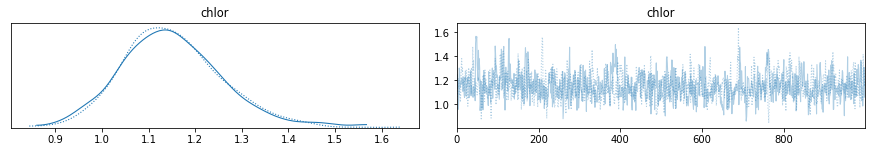

In [17]:
PyMCModel.evaluate_fit(pm_mdl, show_feats='chlor');

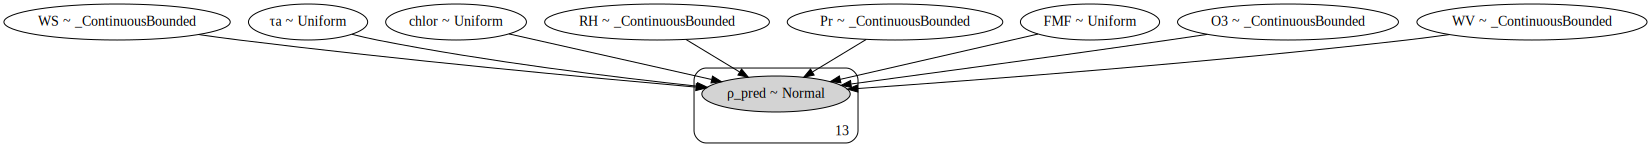

In [9]:
PyMCModel.show_model(pm_mdl)

In [18]:
PyMCModel.summary(pm_mdl, show_feats=None)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
RH,61.480,0.891,59.892,63.191,0.023,0.016,1558.0,1553.0,1562.0,1373.0,1.0
O3,0.442,0.006,0.429,0.454,0.000,0.000,1175.0,1167.0,1200.0,977.0,1.0
Pr,1155.238,7.026,1142.575,1168.778,0.275,0.195,652.0,650.0,689.0,802.0,1.0
WS,8.393,0.125,8.142,8.613,0.003,0.002,1704.0,1703.0,1705.0,1528.0,1.0
WV,30.000,0.000,30.000,30.000,0.000,0.000,2297.0,2297.0,1432.0,804.0,1.0
FMF,37.311,3.616,30.064,43.225,0.142,0.100,650.0,650.0,674.0,1027.0,1.0
τa,0.084,0.001,0.082,0.086,0.000,0.000,1085.0,1085.0,1080.0,1148.0,1.0
chlor,1.152,0.108,0.951,1.351,0.004,0.003,743.0,713.0,812.0,852.0,1.0


In [12]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
RH,72.508,5.536,60.232,81.503,0.920,0.656,36.0,36.0,44.0,32.0,1.04
O3,0.479,0.016,0.451,0.500,0.002,0.001,83.0,82.0,66.0,60.0,1.04
Pr,1157.629,7.675,1145.593,1173.730,0.734,0.522,109.0,109.0,136.0,76.0,1.02
WS,7.935,2.819,3.213,12.288,0.523,0.376,29.0,29.0,30.0,46.0,1.04
WV,30.219,0.194,30.000,30.547,0.015,0.011,160.0,160.0,89.0,64.0,1.01
FMF,35.709,4.812,27.912,44.758,0.484,0.343,99.0,99.0,98.0,125.0,1.02
τa,0.089,0.004,0.081,0.095,0.001,0.000,68.0,68.0,74.0,60.0,1.02
chlor,1.465,0.179,1.134,1.812,0.014,0.010,175.0,172.0,176.0,152.0,1.00


In [28]:
trace.chains[0]

0

In [9]:
ρ_obs

array([0.3540061 , 0.31756118, 0.28843158, 0.26350656, 0.2118493 ,
       0.19553697, 0.18856958, 0.14801267, 0.14763978, 0.14663665,
       0.12892458, 0.10226407, 0.10208727], dtype=float32)

In [36]:

def get_sigma(ρt, solz):

    F0 = 10*np.array([172.912, 187.622, 205.878, 194.933, 185.747,
                      186.539, 183.869, 157.811, 152.255, 148.052,
                      128.065, 97.174, 95.824, 45.467, 23.977, 9.885])
    rad = np.pi/F0[0:13]/np.cos(np.deg2rad(solz))
    C0 = np.array([0.05499859, 0.0293947, 0.11931482, 0.01927545, 0.01397522,
                   0.01139088, 0.08769538, 0.10406925, 0.00496291, 0.00427147,
                   0.00416994, 0.004055895, 0.00312263, 0.07877732, 0.01743281,
                   0.00628912])
    C1 = np.array([0.0000834, 0.0000938, 0.00008195, 0.0000945, 0.0001004,
                   0.0001648, 0.00007, 0.00008533, 0.0001405, 0.0001316,
                   0.0002125, 0.00019755, 0.000186, 0.0004994, 0.001044864,
                   0.0002116])
    Lt = ρt/rad
    noise = C0[0:13] + C1[0:13] * Lt
    snr = Lt / noise
    sigma = 1 / snr
    return sigma/10


In [37]:
ρ_obs/get_sigma(ρ_obs, solz)

array([2683.55158974, 3214.8074205 ,  736.09255089, 2601.59638287,
       1798.05692967, 1479.88767024,  253.83689223,   64.09814292,
        790.41263906,  822.36856052,  407.27303738,  177.4864109 ,
        212.39131551])

NameError: name 'wl' is not defined

In [20]:
import matplotlib.pyplot as plt

(array([  19.,  151.,  676., 1712., 2670., 2572., 1547.,  523.,  114.,
          16.]),
 array([0.28784519, 0.2879646 , 0.28808402, 0.28820344, 0.28832286,
        0.28844228, 0.2885617 , 0.28868111, 0.28880053, 0.28891995,
        0.28903937]),
 <a list of 10 Patch objects>)

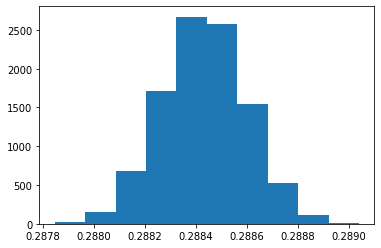

In [30]:
i=2
plt.hist(np.random.normal(ρ_obs[i], get_sigma(ρ_obs, solz)[i], 10000))

In [34]:
100*get_sigma(ρ_obs, solz)/ρ_obs

array([0.22296426, 0.15159452, 0.5757189 , 0.14774653, 0.17910094,
       0.20975705, 1.09091828, 2.42258576, 0.21265109, 0.19516246,
       0.31873255, 0.50673759, 0.42785735])

In [42]:
import pymc3 as pm

In [45]:
from pymc3.variational.callbacks import CheckParametersConvergence


In [97]:
PyMCModel.fit_ADVI(pm_mdl)

Average Loss = -66.977: 100%|██████████| 100000/100000 [03:10<00:00, 526.08it/s] 
Finished [100%]: Average Loss = -66.963


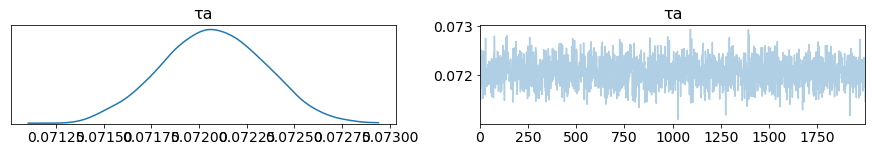

In [111]:
PyMCModel.evaluate_fit(pm_mdl, show_feats='τa');

In [30]:
# %%timeit
x = PyMCModel.fit_MAP(pm_mdl)

logp = -1.3e+06, ||grad|| = 3.6494: 100%|██████████| 64/64 [00:00<00:00, 343.40it/s]      


In [83]:
x

{'RH_interval__': array(-0.06610803),
 'O3_interval__': array(1.44211892),
 'Pr_interval__': array(1.98848342),
 'WS_interval__': array(0.22659202),
 'WV_interval__': array(-18.65715813),
 'FMF_interval__': array(-0.44301784),
 'τa_interval__': array(-1.45045384),
 'chlor_interval__': array(-2.07560938),
 'RH': array(61.42615365),
 'O3': array(0.44263473),
 'Pr': array(1151.83284659),
 'WS': array(8.390448),
 'WV': array(30.0000997),
 'FMF': array(39.10221148),
 'τa': array(0.08407337),
 'chlor': array(1.11579012)}

In [46]:
import pandas as pd

In [55]:
z = pd.DataFrame(x, index=[0])

In [82]:
pd.DataFrame(z.loc[0, labels]).T

,RH,FMF,Pr
0,61.426154,39.102211,1151.832847


In [77]:
labels = ['RH', 'FMF', 'Pr']

In [136]:
pm.summary(trace, var_names=['FMF'])

TypeError: object of type 'NoneType' has no len()

In [8]:
PyMCModel.s

acModel.PyMCModel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma


In [2]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))


Running on PyMC3 v3.7


In [3]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)


In [4]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1550.05draws/s]


In [7]:
pm.summary(trace).round(2)


TypeError: concat() got an unexpected keyword argument 'join_axes'

In [17]:
PyMCModel.predict(pm_mdl)

100%|██████████| 200/200 [00:00<00:00, 312.10it/s]


{'ρ_pred': array([[0.1877822 , 0.15152517, 0.12804003, ..., 0.02615015, 0.01761439,
         0.01936067],
        [0.18803908, 0.1514236 , 0.12751975, ..., 0.02609985, 0.01724383,
         0.01925779],
        [0.18749977, 0.15126582, 0.12780002, ..., 0.02578259, 0.01744125,
         0.01974387],
        ...,
        [0.18731696, 0.15105284, 0.12785146, ..., 0.02579579, 0.01767216,
         0.01955858],
        [0.18772043, 0.1514699 , 0.12754523, ..., 0.02589095, 0.0177578 ,
         0.01933851],
        [0.18745363, 0.15103779, 0.12754106, ..., 0.02604554, 0.01767631,
         0.01986052]])}

In [22]:
assert pm.__version__.startswith('3.8')

In [21]:
pm.__version__

'3.8'

In [28]:
assert '3.8'.startswith('3.8')

In [4]:
from tensorflow import keras

In [5]:
filepath = '../../data/NN_model/NN_fwd_mdl.h5'
m = keras.models.load_model(filepath, compile=False)

In [6]:
m.get_weights()

[array([[-0.15032126,  0.00163997, -0.01489301, ...,  0.00236832,
          0.0065191 ,  0.05029101],
        [-0.20264229,  0.14527808, -0.01501281, ..., -0.00328843,
          0.00443543, -0.0146027 ],
        [ 0.07769166, -0.1395202 , -0.00391817, ..., -0.00151221,
          0.00077944, -0.38753504],
        ...,
        [-0.15653352,  0.2376431 , -0.05023068, ...,  0.17616741,
          0.01585428, -0.12247898],
        [-0.31921124,  0.28537023, -0.02008301, ..., -0.00362954,
          0.22171606,  0.4425221 ],
        [-0.17721623, -0.42604408, -0.05171213, ...,  0.18153608,
          0.5326754 ,  0.09748015]], dtype=float32),
 array([-0.27606586, -0.26673353,  0.02682271, -0.45680627,  0.18892738,
         0.5625559 , -0.21929751, -0.1506162 ,  0.01535012, -0.05172567,
        -0.5417411 , -0.6405258 , -0.27665076,  0.26153284, -0.30996206,
        -0.35936248, -0.05210474, -0.45777345, -0.4243543 , -0.14751244,
        -0.21781553, -0.07563507,  0.        , -0.43198127, -0.582

In [1]:
import xarray as xr
xr.__version__

'0.12.1'

In [6]:
pkg_resources.require()

NameError: name 'xarray' is not defined

In [8]:
import pkg_resources
pkg_resources.require('xarray == 0.15.1')
import xarray as xr
xr.__version__

'0.15.1'

In [4]:
ray_fname = '/Users/aibrahi2/Research/Bayesian_Inference-ML-Atmospheric_Correction/data/tables/Rayleigh_LUT.nc'
print("Opening %s" % (ray_fname))
raylut = xr.open_dataset(ray_fname)
del raylut
# raylut.close


Opening /Users/aibrahi2/Research/Bayesian_Inference-ML-Atmospheric_Correction/data/tables/Rayleigh_LUT.nc


In [5]:
raylut

NameError: name 'raylut' is not defined

In [22]:
xr.Dataset.close(raylut)